In [13]:
import pandas as pd
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import os
import json

# Set NEOS email
os.environ['NEOS_EMAIL'] = 'jihad.jundi@tum.de'

# Load the data
hourly_load_path = 'DataB_hourlyload.csv'
nondisp_generation_path = 'DataB_nondispgeneration.csv'
generator_params_path = 'DataB_generatorparams.csv'

df_hourly_load = pd.read_csv(hourly_load_path, delimiter=';')
df_nondisp_generation = pd.read_csv(nondisp_generation_path, delimiter=';')
df_generator_params = pd.read_csv(generator_params_path, delimiter=';')

# Calculate expected values for each hour
df_nondisp_generation['expected_wind'] = df_nondisp_generation['generation wind'] * df_nondisp_generation['probability wind']
df_nondisp_generation['expected_solar'] = df_nondisp_generation['generation solar'] * df_nondisp_generation['probability solar']

# Group by hour and sum expected values
expected_values = df_nondisp_generation.groupby('hour')[['expected_wind', 'expected_solar']].sum().reset_index()

# Map hours to individual hours from 0 to 23
hour_map = {
    '0-5': list(range(0, 6)),
    '6-10': list(range(6, 11)),
    '11-14': list(range(11, 15)),
    '15-19': list(range(15, 20)),
    '20-23': list(range(20, 24))
}

# Initialize lists for full expected values
full_expected_wind = []
full_expected_solar = []

# Expand the expected values to full hours
for index, row in expected_values.iterrows():
    hours = hour_map[row['hour']]
    full_expected_wind.extend([row['expected_wind']] * len(hours))
    full_expected_solar.extend([row['expected_solar']] * len(hours))

# Create a DataFrame with hourly expected values from 0 to 23
expected_values_full = pd.DataFrame({
    'hour': list(range(24)),
    'expected_wind': full_expected_wind,
    'expected_solar': full_expected_solar
})

# Merge with hourly load data
df_hourly_load['expected_wind'] = expected_values_full['expected_wind']
df_hourly_load['expected_solar'] = expected_values_full['expected_solar']

# Define the optimization model
model = pyo.ConcreteModel()

# Sets
model.T = pyo.RangeSet(0, 23)  # Hours (0 to 23)
model.G = pyo.RangeSet(1, len(df_generator_params))  # Generators (1 to number of generators)

# Parameters
# These parameters hold the data from the CSV files
model.hourly_load = pyo.Param(model.T, initialize=df_hourly_load.set_index('hour')['load'].to_dict())
model.wind = pyo.Param(model.T, initialize=expected_values_full.set_index('hour')['expected_wind'].to_dict())
model.solar = pyo.Param(model.T, initialize=expected_values_full.set_index('hour')['expected_solar'].to_dict())
model.pmin = pyo.Param(model.G, initialize=df_generator_params.set_index('generator')['pmin'].to_dict())
model.pmax = pyo.Param(model.G, initialize=df_generator_params.set_index('generator')['pmax'].to_dict())
model.a1 = pyo.Param(model.G, initialize=df_generator_params.set_index('generator')['a1'].to_dict())
model.a2 = pyo.Param(model.G, initialize=df_generator_params.set_index('generator')['a2'].to_dict())

# Variables
# Binary variable to indicate if a generator is on (1) or off (0)
model.u = pyo.Var(model.G, model.T, within=pyo.Binary)
# Continuous variable to indicate the power generated by each generator
model.p = pyo.Var(model.G, model.T, within=pyo.NonNegativeReals)

# Constraints
# Constraint to ensure the power generated by a generator is at least pmin if it's on
def power_min_rule(model, g, t):
    return model.p[g, t] >= model.pmin[g] * model.u[g, t]
model.power_min = pyo.Constraint(model.G, model.T, rule=power_min_rule)

# Constraint to ensure the power generated by a generator is at most pmax if it's on
def power_max_rule(model, g, t):
    return model.p[g, t] <= model.pmax[g] * model.u[g, t]
model.power_max = pyo.Constraint(model.G, model.T, rule=power_max_rule)

# Constraint to ensure the total generated power exactly equals the load for each hour
def load_balance_rule(model, t):
    return sum(model.p[g, t] for g in model.G) + model.wind[t] + model.solar[t] == model.hourly_load[t]
model.load_balance = pyo.Constraint(model.T, rule=load_balance_rule)

# Objective function to minimize the total cost of generation
def objective_rule(model):
    return sum(model.a2[g] * model.p[g, t] ** 2 + model.a1[g] * model.p[g, t] for g in model.G for t in model.T)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Solve the optimization problem using the NEOS server with cplex solver
optim = pyo.SolverManagerFactory('neos')
results = optim.solve(model, opt="cplex", tee=True)

# Extract results
solution = {
    'u1': [],
    'u2': [],
    'u3': [],
    'p1': [],
    'p2': [],
    'p3': [],
    'uwind': [],
    'usolar': []
}

for t in model.T:
    solution['u1'].append(int(pyo.value(model.u[1, t])))
    solution['u2'].append(int(pyo.value(model.u[2, t])))
    solution['u3'].append(int(pyo.value(model.u[3, t])))
    solution['p1'].append(pyo.value(model.p[1, t]))
    solution['p2'].append(pyo.value(model.p[2, t]))
    solution['p3'].append(pyo.value(model.p[3, t]))
    solution['uwind'].append(int(expected_values_full.loc[t, 'expected_wind'] > 0))
    solution['usolar'].append(int(expected_values_full.loc[t, 'expected_solar'] > 0))

result = {
    'name': 'GroupE',
    'task': 'B',
    'u1': solution['u1'],
    'u2': solution['u2'],
    'u3': solution['u3'],
    'p1': solution['p1'],
    'p2': solution['p2'],
    'p3': solution['p3'],
    'uwind': solution['uwind'],
    'usolar': solution['usolar']
}

# Write the result to a JSON file
with open('result.json', 'w') as f:
    json.dump(result, f, indent=4)

# Print first 48 rows to check the results and the total cost
print(solution)
print(f"Total Cost: {pyo.value(model.objective)}")

{'u1': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'u2': [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], 'u3': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'p1': [200.00000000000003, 252.39999999999998, 247.6, 250.0, 200.00000000000003, 200.00000000000003, 254.79999999999998, 200.00000000000003, 200.00000000000003, 200.00000000000003, 239.2, 246.4, 241.6, 237.39999999999998, 214.0, 234.40000000000003, 226.60000000000002, 228.40000000000003, 245.79999999999998, 212.20000000000002, 200.00000000000003, 200.00000000000003, 200.00000000000003, 245.79999999999998], 'p2': [180.0, 0.0, 0.0, 0.0, 180.0, 180.0, 0.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 180.0, 0.0], 'p3': [54.0, 161.60000000000002, 158.4,

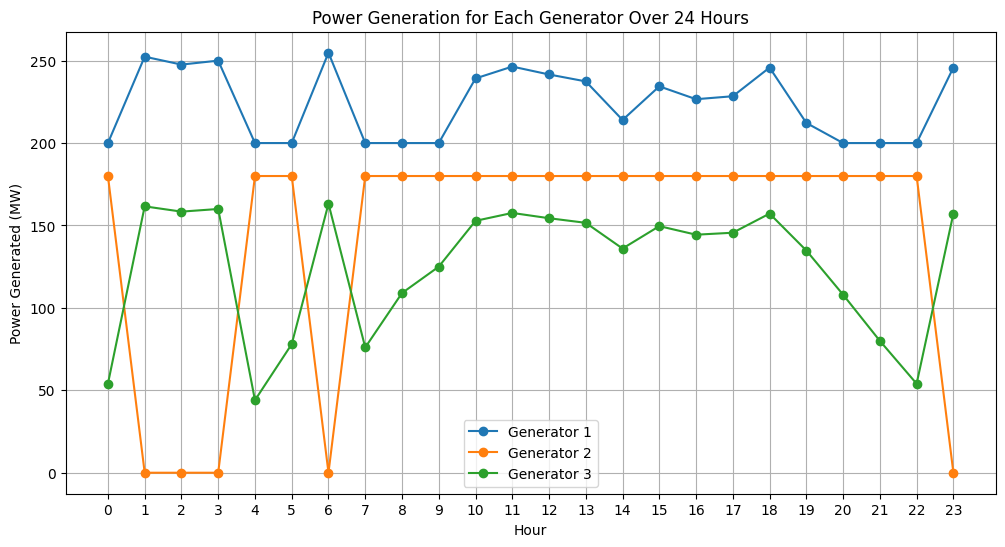

In [10]:
import matplotlib.pyplot as plt

# Plot the power generation for each generator over the 24-hour period
hours = list(range(24))

plt.figure(figsize=(12, 6))

# Plot for Generator 1
plt.plot(hours, solution['p1'], label='Generator 1', marker='o')

# Plot for Generator 2
plt.plot(hours, solution['p2'], label='Generator 2', marker='o')

# Plot for Generator 3
plt.plot(hours, solution['p3'], label='Generator 3', marker='o')

plt.xlabel('Hour')
plt.ylabel('Power Generated (MW)')
plt.title('Power Generation for Each Generator Over 24 Hours')
plt.legend()
plt.grid(True)
plt.xticks(hours)  # Ensure all hours are displayed on the x-axis
plt.show()
